### GAN 훈련 성능 향상하기 

* 모드 붕괴를 고치고 이미지 선명도를 높이기 위한 방법
* 훈련 품질을 높이자 

* BCELoss를 이용해 MSELoss를 대체
    * 분류 문제에서 이손실 함수가 더 잘 작동함 : 보상과 벌이 강하기 때문
* 활성화 함수를 LeakyReLU()로 적용.
    * sigmoid는 가장 마지막 layer에만 적용 
* LayerNormalization 적용 
* optimizer Adam 사용 
* input node의 개수를 늘리기 


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas, numpy, random
import matplotlib.pyplot as plt

In [2]:
# dataset class
# data를 tensor로 묶고, 각 레코드마다 정답 레이블, 0부터 1사이의 값으로 재조정된 이미지 픽셀값, 원핫 인코딩이 된 텐서를 반환

class MnistDataset(Dataset):
    
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        # image target (label)
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0
        
        # image data, normalised from 0-255 to 0-1
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0
        
        # return label, image data tensor and target tensor
        return label, image_values, target
    
    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')
        pass
    
    pass

In [5]:
# load data

mnist_dataset = MnistDataset('mnist_train.csv')

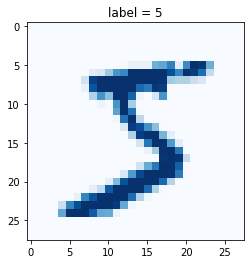

In [6]:
# check data contains images

mnist_dataset.plot_image(0)

In [7]:
# function to generate uniform random data
# 원하는 size의 ramdom data를 생성 

def generate_random(size):
    random_data = torch.rand(size)
    return random_data

In [8]:
# discriminator class

class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.LeakyReLU(0.02),
            
            nn.LayerNorm(200),
            nn.Linear(200, 1),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

In [10]:
%%time 

# 작업시간 측정
# test discriminator can separate real data from random noise
# 진짜 숫자라고 판단하면 결과를 1.0으로 출력

D = Discriminator()

for label, image_data_tensor, target_tensor in mnist_dataset:
    # real data
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    # fake data
    D.train(generate_random(784), torch.FloatTensor([0.0]))
    pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 3min 14s, sys: 55.6 s, total: 4min 9s
Wall time: 2min 45s


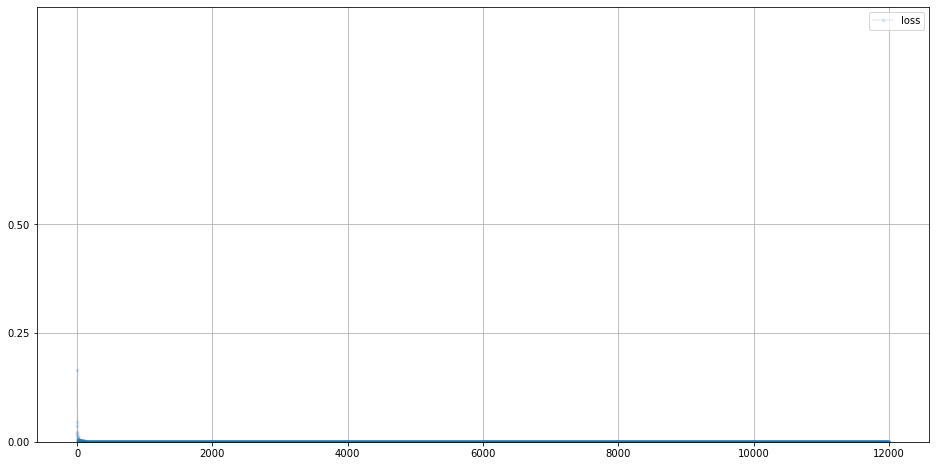

In [11]:
# plot discriminator loss
# loss가 0근처에서 유지됨 

D.plot_progress()

In [12]:
# manually run discriminator to check it can tell real data from fake
# 실제 데이터를 수동으로 넣어서 결과 확인 

# 실제데이터의 확률
for i in range(4):
    image_data_tensor = mnist_dataset[random.randint(0,60000)][1]
    print( D.forward( image_data_tensor ).item() )
    pass

# 가짜데이터의 확률
for i in range(4):
    print( D.forward( generate_random(784) ).item() )
    pass

1.0
1.0
1.0
1.0
9.841530368426277e-12
8.854627968346573e-12
9.873831786910703e-12
8.608429941103779e-12


In [22]:
# generator class

class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers 28x28=784
        self.model = nn.Sequential(
#             nn.Linear(1, 200),
            nn.Linear(100, 200), # 더 많은 입력노드를 넣게 모델 수정 
            
            nn.LeakyReLU(0.02),
            
            nn.LayerNorm(200),
            
            nn.Linear(200, 784),
            nn.Sigmoid()
        )
        
        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        # simply run model
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

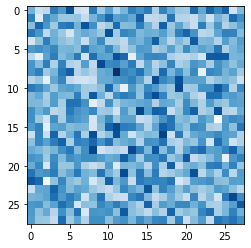

In [14]:
# 훈련하기 전 생성기의 output이 잘 생성 되는지 확인

G = Generator()

output = G.forward(generate_random(1))

img = output.detach().numpy().reshape(28,28)

plt.imshow(img, interpolation='none', cmap='Blues')

In [15]:
%%time 

# create Discriminator and Generator

D = Discriminator()
G = Generator()

# train Discriminator and Generator

for label, image_data_tensor, target_tensor in mnist_dataset:

    # train discriminator on true : 실제 데이터 - 1.0
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    
    # train discriminator on false : 가짜 데이터 - 0.0
    # use detach() so gradients in G are not calculated : G의 기울기가 계산되지 않게 detach 사용
    D.train(G.forward(generate_random(1)).detach(), torch.FloatTensor([0.0]))
    
    # train generator 
    G.train(D, generate_random(1), torch.FloatTensor([1.0]))

    pass


counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 5min 35s, sys: 1min 28s, total: 7min 4s
Wall time: 4min 44s


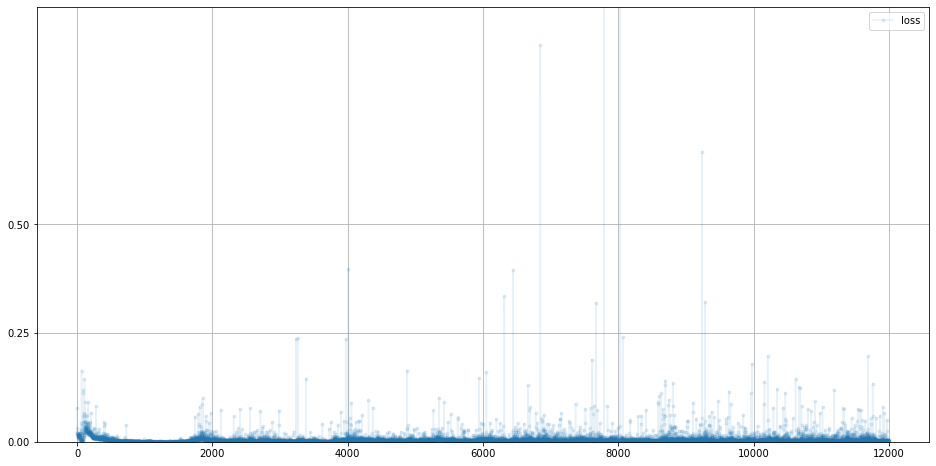

In [16]:
# plot discriminator error
# loss가 0에 가까운 경우 : 판별기가 생성기를 앞섬, 생성기의 성능이 떨어져서 속일수 없는 상태
# loss가 0.25일때 판별기와 생성기의 균형이 맞음

D.plot_progress()

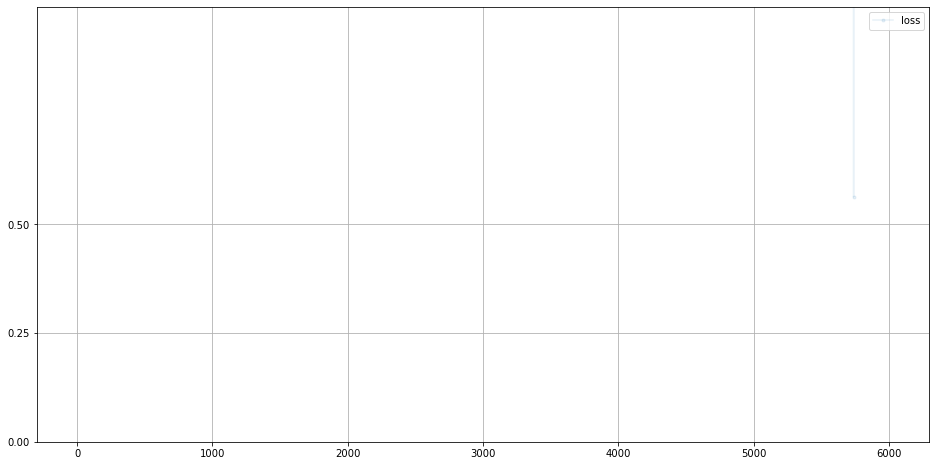

In [17]:
# plot generator error
# 초기 : 잘 구별함
# 0.25근처 : 잘 구별 못함 - 균형이 맞음 
# 이후 다시 잘 구별함 


G.plot_progress()

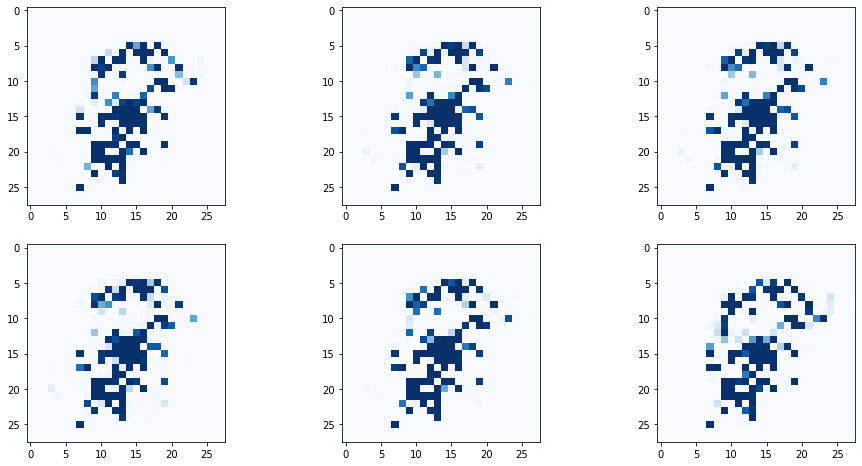

In [18]:
# plot several outputs from the trained generator

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random(1))
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

### 판별기와 생성기에 주는 random값이 달라져야함
* 판별기 입력 random값 :  0~1사이의 이미지 픽셀값, 경향이 없는 데이터 
* 생성기 입력 random값 : 0~1사이가 아니어도 상관 없는 값, 표준 정규분포를 따르는 값이 더 유리

In [20]:
# 판별기 input 
def generate_random_image(size) :
    random_data = torch.rand(size)
    return random_data

In [21]:
# 생성기 input
def generate_random_seed(size) :
    random_data = torch.randn(size)
    return random_data

In [23]:
%%time 

# create Discriminator and Generator

D = Discriminator()
G = Generator()

# train Discriminator and Generator

for label, image_data_tensor, target_tensor in mnist_dataset:

    # train discriminator on true : 실제 데이터 - 1.0
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    
    # train discriminator on false : 가짜 데이터 - 0.0
    # use detach() so gradients in G are not calculated : G의 기울기가 계산되지 않게 detach 사용
    D.train(G.forward(generate_random_seed(100)).detach(), torch.FloatTensor([0.0]))
    
    # train generator 
    G.train(D, generate_random_seed(100), torch.FloatTensor([1.0]))

    pass


counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 5min 31s, sys: 1min 29s, total: 7min
Wall time: 4min 41s


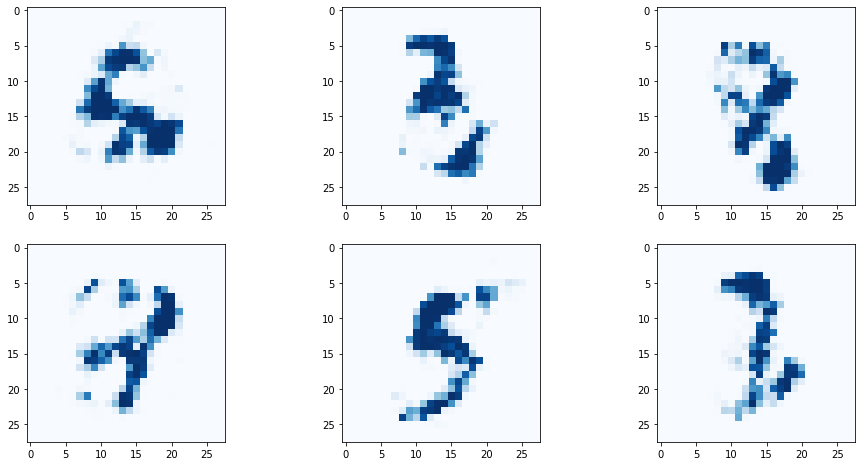

In [25]:
# plot several outputs from the trained generator

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

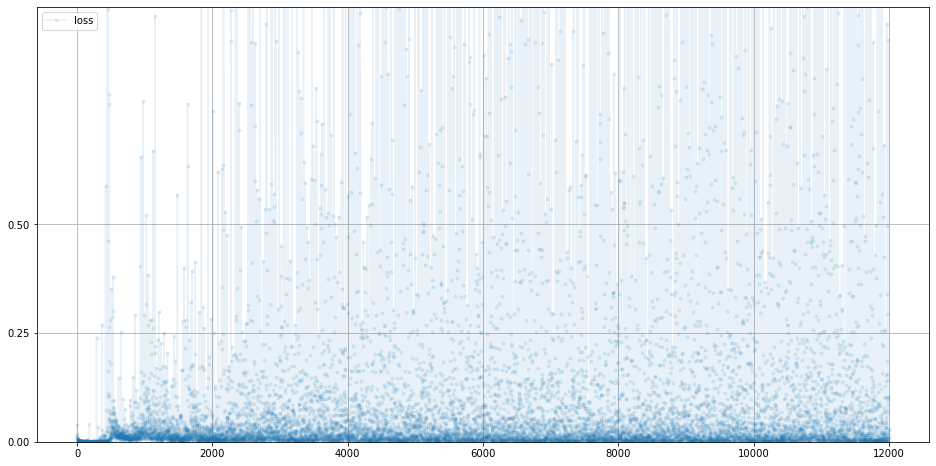

In [26]:
D.plot_progress()
    

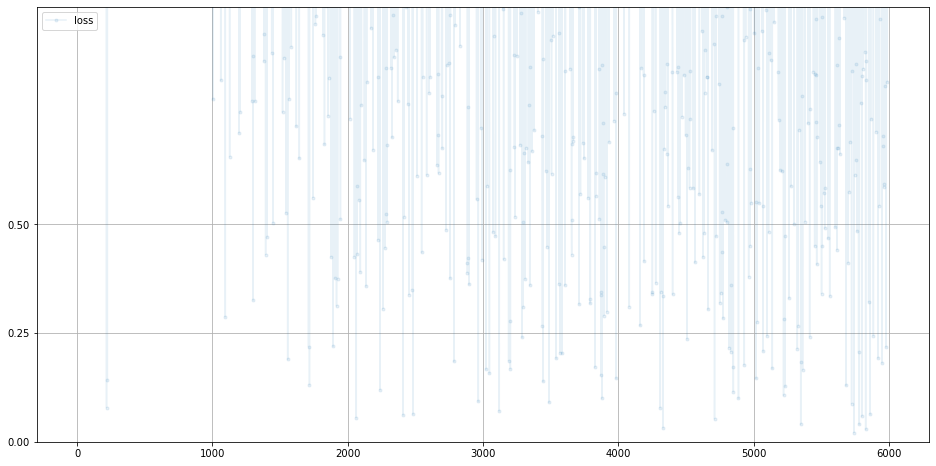

In [28]:
G.plot_progress()